In [1]:
%matplotlib inline

import cv2, matplotlib
import numpy as np
from skimage.morphology import (
    skeletonize,
    skeletonize_3d,
    medial_axis,
    thin,
    local_minima,
    local_maxima,
)
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.ndimage import distance_transform_edt

from math import sqrt

import matplotlib.pyplot as plt

from os.path import expanduser, splitext
from os import scandir, makedirs

# import random

import csv

from tqdm import tnrange, tqdm_notebook

from pathlib import Path

debug = False  # plot every steps

In [2]:
from floorplan_analysis import read_bgr_from_image_unicode
from floorplan_analysis import read_from_csv

from floorplan_analysis import get_unit_mask

from floorplan_analysis import align_fp, rescale_fp
from floorplan_analysis import mono_fp
from floorplan_analysis import read_mono_from_image_unicode, save_mono_to_image_unicode

# process files

In [21]:
def process_floorplan_mono(
    path_from, area, filename_to, dir_to="/data/fp_img_processed/", ext_to=".png"
):
    try:
        bgr = read_bgr_from_image_unicode(path_from)
        unit_comb = get_unit_mask(bgr)
        unit_comb = rescale_fp(unit_comb, area)
        unit_comb = align_fp(unit_comb)

        mono = mono_fp(unit_comb)
        save_mono_to_image_unicode(mono, dir_to + filename_to + ext_to, ext_to)
    except:
        print(filename_to)

In [4]:
process_floorplan_mono("/fp_img/10001_57B.jpg", 85, "mono", dir_to="")

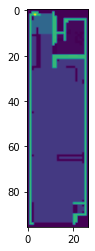

In [5]:
plt.imshow(read_mono_from_image_unicode("mono.png"))

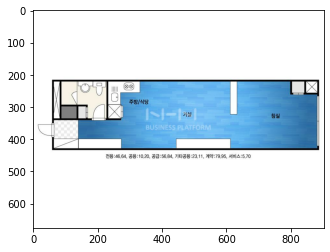

In [6]:
bgr = read_bgr_from_image_unicode("/fp_img/10001_57B.jpg")
plt.imshow(bgr)

In [7]:
unit_comb = get_unit_mask(bgr)

In [8]:
unit_comb = rescale_fp(unit_comb, 85)

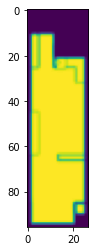

In [9]:
unit_comb = align_fp(unit_comb)
plt.imshow(unit_comb[:, :, 2])

In [10]:
mono = mono_fp(unit_comb)

# multiprocessing

In [11]:
from multiprocessing import Pool


def worker(x, y):
    return x * y


with Pool(7) as p:
    output = p.starmap(worker, [(i, 2 * i) for i in range(101)], chunksize=100)

print(output)

[0, 2, 8, 18, 32, 50, 72, 98, 128, 162, 200, 242, 288, 338, 392, 450, 512, 578, 648, 722, 800, 882, 968, 1058, 1152, 1250, 1352, 1458, 1568, 1682, 1800, 1922, 2048, 2178, 2312, 2450, 2592, 2738, 2888, 3042, 3200, 3362, 3528, 3698, 3872, 4050, 4232, 4418, 4608, 4802, 5000, 5202, 5408, 5618, 5832, 6050, 6272, 6498, 6728, 6962, 7200, 7442, 7688, 7938, 8192, 8450, 8712, 8978, 9248, 9522, 9800, 10082, 10368, 10658, 10952, 11250, 11552, 11858, 12168, 12482, 12800, 13122, 13448, 13778, 14112, 14450, 14792, 15138, 15488, 15842, 16200, 16562, 16928, 17298, 17672, 18050, 18432, 18818, 19208, 19602, 20000]


# main

In [12]:
dir_ID_from = "/fp_img/"
dir_IDs_exclude = "/data/exclude/"

dir_from = "/fp_img/"

dir_to = "/data/fp_img_processed/"
makedirs(dir_to, exist_ok=True)

ext_to = ".png"

### all of the plans
ID_ext_dict = {
    splitext(f.name)[0]: splitext(f.name)[1]
    for f in scandir(dir_ID_from)
    if f.is_file()
}
print(len(ID_ext_dict.keys()), "floorplans")

51551 floorplans


In [13]:
list(ID_ext_dict.items())[:10]

[('19679_64G', '.jpg'),
 ('883_153', '.jpg'),
 ('11545_171', '.jpg'),
 ('9251_67', '.jpg'),
 ('10784_242', '.jpg'),
 ('26462_151', '.jpg'),
 ('19073_116B', '.jpg'),
 ('106721_165C', '.jpg'),
 ('103551_117B', '.jpg'),
 ('24036_77', '.jpg')]

In [14]:
files_IDs_exclude = list(Path(expanduser(dir_IDs_exclude)).glob("*.csv"))

# don't repeat the process
files_IDs_exclude.append(Path('processed.csv'))

print(files_IDs_exclude)

[PosixPath('/data/exclude/fp_img_multi-level.csv'), PosixPath('/data/exclude/fp_img_multi-unit.csv'), PosixPath('/data/exclude/fp_img_exclude.csv'), PosixPath('processed.csv')]


In [15]:
IDs_excl = set()
for file_excl in files_IDs_exclude:
    _, file_excl_list = read_from_csv(str(file_excl))
    if file_excl_list:
        list_excl = [row[0] for row in file_excl_list]
    IDs_excl |= set(list_excl)
    print(file_excl, "processed:", len(list_excl), "floorplans to exclude")

# _, fp_img_processed_list = read_from_csv(exp_path_fp_img)
# if fp_img_processed_list:
#     list_excl = [row[0] for row in fp_img_processed_list]
#     IDs_excl |= set(list_excl)
#     print(len(list_excl), "floorplans already processed")

/data/exclude/fp_img_multi-level.csv processed: 861 floorplans to exclude
/data/exclude/fp_img_multi-unit.csv processed: 15 floorplans to exclude
/data/exclude/fp_img_exclude.csv processed: 861 floorplans to exclude
processed.csv processed: 50252 floorplans to exclude


In [16]:
import pandas as pd

path_csv = "fp_refined.csv"

df = pd.read_csv(path_csv)
df = df.set_index("id_after")
df

,Path,index,APT_ID,Date,year,norm_year,yyyymm,N_Housings,Max_Floors,Min_Floors,...,sido_cluster_code,sido_sgg_name,FP_ID,Area,norm_log_area,area_85,Entrance,Rooms,Baths,N_Units
id_after,,,,,,,,,,,,,,,,,,,,,
8928_160,/data/fp_img_processed/8928_160.png,1,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,20,...,0,서울시 강남구,160,134.30,1.313282,False,계단식,4,2,84
8928_183,/data/fp_img_processed/8928_183.png,2,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,20,...,0,서울시 강남구,183,153.80,1.702528,False,계단식,4,2,44
8928_201A,/data/fp_img_processed/8928_201A.png,3,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,20,...,0,서울시 강남구,201A,170.32,1.995448,False,계단식,4,2,42
8928_204B,/data/fp_img_processed/8928_204B.png,4,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,20,...,0,서울시 강남구,204B,168.42,1.963240,False,계단식,4,2,42
960_35,/data/fp_img_processed/960_35.png,5,960,1982-11-01T00:00:00Z,1982,0.26,198211,5040,5,5,...,0,서울시 강남구,35,35.64,-2.495452,False,계단식,2,1,530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115454_21D,/data/fp_img_processed/115454_21D.png,50577,115454,2017-03-01T00:00:00Z,2017,0.96,201703,72,4,4,...,8,제주도 제주시,21D,14.50,-5.077429,False,계단식,2,1,20
115454_34E,/data/fp_img_processed/115454_34E.png,50578,115454,2017-03-01T00:00:00Z,2017,0.96,201703,72,4,4,...,8,제주도 제주시,34E,21.57,-3.937185,False,계단식,2,1,4
115454_36B,/data/fp_img_processed/115454_36B.png,50579,115454,2017-03-01T00:00:00Z,2017,0.96,201703,72,4,4,...,8,제주도 제주시,36B,24.86,-3.529623,False,계단식,3,2,16


In [17]:
ID_set = set(ID_ext_dict.keys()).difference(IDs_excl)
ID_set = ID_set.intersection(df.index)
IDs = list(ID_set)
print(len(IDs), "floorplans to go")

288 floorplans to go


In [18]:
paths_from = [dir_from + ID + ID_ext_dict[ID] for ID in IDs]
print(paths_from[:10])

['/fp_img/23829_114.jpg', '/fp_img/22555_79D.jpg', '/fp_img/14366_40A.jpg', '/fp_img/10668_109B.jpg', '/fp_img/11388_116.jpg', '/fp_img/9785_168.jpg', '/fp_img/26792_276.jpg', '/fp_img/16893_103.jpg', '/fp_img/8771_81.jpg', '/fp_img/1333_60.jpg']


In [19]:
df.Area

id_after
8928_160      134.30
8928_183      153.80
8928_201A     170.32
8928_204B     168.42
960_35         35.64
               ...  
115454_21D     14.50
115454_34E     21.57
115454_36B     24.86
115454_37A     25.67
115454_38C     25.21
Name: Area, Length: 50540, dtype: float64

In [20]:
area_list = [df.Area[ID] for ID in IDs]
area_list[:10]

[84.99, 59.98, 31.37, 84.84, 84.87, 133.48, 240.18, 75.9, 67.88, 44.1]

In [22]:
from multiprocessing import Pool

makedirs(dir_to, exist_ok=True)

with Pool(7) as p:
    p.starmap(process_floorplan_mono, zip(paths_from, area_list, IDs))

22522_145A
102629_114D1
23829_114
19635_177B
22071_134
27446_113B
218_99
26771_102E
1333_95
9905_218
22555_79D
9936_92
4116_70
1705_91
3410_337
102424_118
12233_93B
26624_108
19492_100
392_106
27766_181


/tf/notebooks/NaverFloorplanAnalysis/floorplan_analysis.py:826: RuntimeWarning: divide by zero encountered in double_scalars
  scale = sqrt(area * target_ppm ** 2 / pixels)
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:153: RuntimeWarning: invalid value encountered in multiply
  dst_corners[:, 0] = factors[1] * (src_corners[:, 0] + 0.5) - 0.5
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:154: RuntimeWarning: invalid value encountered in multiply
  dst_corners[:, 1] = factors[0] * (src_corners[:, 1] + 0.5) - 0.5
/usr/local/lib/python3.6/dist-packages/skimage/transform/_geometric.py:53: RuntimeWarning: invalid value encountered in subtract
  rms = math.sqrt(np.sum((points - centroid) ** 2) / points.shape[0])
/usr/local/lib/python3.6/dist-packages/skimage/transform/_geometric.py:63: RuntimeWarning: invalid value encountered in matmul
  new_pointsh = (matrix @ pointsh).T


14366_40A
10784_242
25296_90
503_91
10668_109B
8759_141
17374_140
101391_113B
11388_116
13457_171L
22151_140A
101942_150C
24772_201
9785_168
25852_121
224_79
10251_182
3787_82C
26028_110C
17506_111A
17709_277
17358_119A
9218_222A
106633_111A
108927_63B
8397_65B
100354_165
9642_184A
21870_49
8806_74
26792_276
25852_150
24456_155A
26789_156
3143_177M
16893_103
26942_160B
2549_162
12232_186
8481_97
9913_78
8771_81
19200_122B
12913_71
22354_208
1333_60
22245_80B
17554_228B
11388_109A
8217_212
18901_163B
17263_140
11638_83
107888_34D3
18894_114
24704_184
6856_112
3255_55
17515_137
227_81A
9785_204
17634_110
22151_128A
8783_56
27578_98B
27685_149
3270_141
103065_79C
12235_53
1638_158
1991_191
25155_201
27893_111A
10758_94
572_104
3786_85C
3807_159
2198_157
19635_205
25935_179C
690_104
9743_161
10668_100A
12796_63
1210_129
17420_109A
13311_161
22065_116B
27533_134
27080_107
114538_93
26420_141A
8971_301
22398_221
21870_56
12235_43C
3410_297B
26521_143A
19706_110A
19686_42
3104_218B
13457_128D

/tf/notebooks/NaverFloorplanAnalysis/floorplan_analysis.py:826: RuntimeWarning: divide by zero encountered in double_scalars
  scale = sqrt(area * target_ppm ** 2 / pixels)
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:153: RuntimeWarning: invalid value encountered in multiply
  dst_corners[:, 0] = factors[1] * (src_corners[:, 0] + 0.5) - 0.5
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:154: RuntimeWarning: invalid value encountered in multiply
  dst_corners[:, 1] = factors[0] * (src_corners[:, 1] + 0.5) - 0.5
/usr/local/lib/python3.6/dist-packages/skimage/transform/_geometric.py:53: RuntimeWarning: invalid value encountered in subtract
  rms = math.sqrt(np.sum((points - centroid) ** 2) / points.shape[0])
/usr/local/lib/python3.6/dist-packages/skimage/transform/_geometric.py:63: RuntimeWarning: invalid value encountered in matmul
  new_pointsh = (matrix @ pointsh).T


14366_51
6489_142
27631_79B
10058_107D
10828_176C
25842_113C
3375_84
3371_153
7770_111A
17506_111
101611_113B
102628_111C2
13187_76
14366_41A
7368_144
26157_173
19686_34A
6598_152
301_64
13457_178F
102628_110C1
104384_88
102622_145B
26228_112A
12826_182
14039_111A
25542_57
102622_145A
17425_241C
13918_69A
100702_130B
8776_275
425_134
12_53
14366_41B
3575_152A
17330_163
8229_115
1915_154
10088_182
1320_89


KeyboardInterrupt: 

    ls /data/fp_img_processed/ | wc -l